3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
1.5.1
None
tensor([0.5341, 0.4659], grad_fn=<SoftmaxBackward>)
tensor([0.5341, 0.4659], grad_fn=<SoftmaxBackward>)
Ep: 1000Moyenne mobile des derniers 10: 120.20

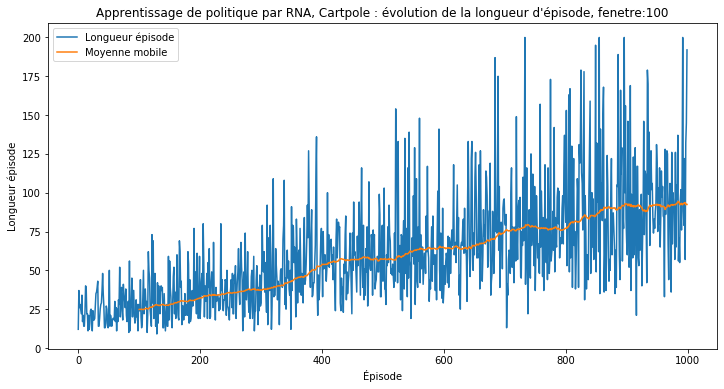

In [15]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
AR Apprentissage de politique par RNA
Cartpole
"""
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

import torch
from torch import nn
from torch import optim

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

class EstimateurPi():
    def __init__(self, env):
        self.dim_etat = env.observation_space.shape[0]
        self.nb_actions = env.action_space.n
        
        self.rna_preference_action = nn.Sequential(
            nn.Linear(self.dim_etat, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.nb_actions),
            nn.Softmax(dim=-1))
    
    def predict(self, etat):
        probabilites_actions = self.rna_preference_action(torch.FloatTensor(etat))
        return probabilites_actions
    
env = gym.make('CartPole-v0')
etat = env.reset()
estimateur = EstimateurPi(env)
print(estimateur.predict(etat))
print(estimateur.rna_preference_action(torch.FloatTensor(etat)))

def calculer_retours_escomptees(recompenses, gamma=0.99):
    """ Calculer les retours escomptés à partir des récompenses pour chaque t"""
    recompenses_escomptees = np.array([gamma**t * recompenses[t] for t in range(len(recompenses))])
    retours_escomptees = recompenses_escomptees[::-1].cumsum()[::-1]
    return retours_escomptees - retours_escomptees.mean()

def reinforce(env, EstimateurPi,nombre_episodes=1000,taille_lot=10, gamma=0.99):

    total_recompenses = []
    lot_retours_escomptes = []
    lot_actions = []
    lot_etats = []
    lot_compteur = 1
    optimiseur = optim.Adam(EstimateurPi.rna_preference_action.parameters(),lr=0.01)
    ensemble_actions = np.arange(env.action_space.n)
    
    for episode in range(nombre_episodes):
        etat = env.reset()
        etats = []
        recompenses = []
        actions = []
        fin_episode = False
        while fin_episode == False:

            probabilites_actions = EstimateurPi.predict(etat).detach().numpy()
            action = np.random.choice(ensemble_actions, p=probabilites_actions)
            etat_suivant, recompense, fin_episode, _ = env.step(action)
            etats.append(etat)
            recompenses.append(recompense)
            actions.append(action)
            etat = etat_suivant
            
            if fin_episode:
                lot_retours_escomptes.extend(calculer_retours_escomptees(recompenses, gamma))
                lot_etats.extend(etats)
                lot_actions.extend(actions)
                lot_compteur += 1
                total_recompenses.append(sum(recompenses))
                
                if lot_compteur == taille_lot:
                    # Apprentissage à partir du lot 
                    optimiseur.zero_grad()
                    lot_etats_tensor = torch.FloatTensor(lot_etats)
                    lot_retours_escomptes_tensor = torch.FloatTensor(lot_retours_escomptes)
                    lot_actions_tensor_long = torch.LongTensor(lot_actions)
                    
                    # Calculer le cout
                    lot_log_prob_actions = torch.log(EstimateurPi.predict(lot_etats_tensor))
                    lot_logprobs_actions_choisies = lot_retours_escomptes_tensor * lot_log_prob_actions[np.arange(len(lot_actions_tensor_long)), lot_actions_tensor_long]
                    cout = -lot_logprobs_actions_choisies.mean()
                    
                    # Calculer gradients
                    cout.backward()
                    optimiseur.step()
                    
                    lot_retours_escomptes = []
                    lot_actions = []
                    lot_etats = []
                    lot_compteur = 1
                    
                print("\rEp: {}Moyenne mobile des derniers 10: {:.2f}".format(episode + 1, np.mean(total_recompenses[-10:])), end="")
                
    return total_recompenses


recompenses = reinforce(env, estimateur)
window = 10
smoothed_recompenses = [np.mean(recompenses[i-window:i+1]) if i > window 
                    else np.mean(recompenses[:i+1]) for i in range(len(recompenses))]
def afficher_longueur_episode(longueur_episode, fenetre=10):
    """
    Afficher l'évolution des longueurs d'épisodes avec le temps
    """
    plt.figure(figsize=(12,6))
    plt.plot(longueur_episode,label="Longueur épisode")
    longueur_moyenne_fenetre=[np.mean(longueur_episode[i:i+fenetre]) for i in range(len(longueur_episode)-fenetre)]
    plt.plot(np.arange(fenetre,len(longueur_episode)),longueur_moyenne_fenetre,label="Moyenne mobile")
    plt.xlabel("Épisode")
    plt.ylabel("Longueur épisode")
    plt.title("Apprentissage de politique par RNA, Cartpole : évolution de la longueur d'épisode, fenetre:"+str(fenetre))
    plt.legend(loc='upper left')
    plt.show()

afficher_longueur_episode(recompenses, fenetre=100)


